In [ ]:
import os
import time
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
                                     Dense, Dropout, Flatten,BatchNormalization)
from tensorflow.keras.applications import (MobileNet, ResNet50, EfficientNetB0)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

zip_path = '/content/drive/MyDrive/archive.zip'

extract_path = '/content/skin_cancer_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
meta_df = pd.read_csv(os.path.join(extract_path, 'HAM10000_metadata.csv'))

lesion_group = meta_df.groupby('lesion_id').count().reset_index()
unique_lesions = lesion_group[lesion_group['image_id']==1]['lesion_id']
meta_df['is_duplicate'] = ~meta_df['lesion_id'].isin(unique_lesions)
clean_df = meta_df[meta_df['is_duplicate']==False]

train_df, val_df = train_test_split(
    clean_df, test_size=0.18, stratify=clean_df['dx'], random_state=42
)

meta_df['data_split'] = meta_df['image_id'].map(
    lambda img: 'val' if img in val_df['image_id'].values else 'train'
)
img1 = os.path.join(extract_path, 'ham10000_images_part_1')
img2 = os.path.join(extract_path, 'ham10000_images_part_2')
files1, files2 = set(os.listdir(img1)), set(os.listdir(img2))
def resolve_path(id):
    fn = f"{id}.jpg"
    if fn in files1: return os.path.join(img1,fn)
    if fn in files2: return os.path.join(img2,fn)
    return None

meta_df['image_path'] = meta_df['image_id'].apply(resolve_path)
meta_df.dropna(subset=['image_path'], inplace=True)
train_df = meta_df[meta_df['data_split']=='train']
val_df   = meta_df[meta_df['data_split']=='val']

print("Train:", len(train_df), "Val:", len(val_df))

Train: 9022 Val: 993


In [ ]:

IMAGE_SIZE = (224,224)
BATCH_SIZE = 16

from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preproc

def get_generators(df_train, df_val, preprocess_fn):
    train_aug = ImageDataGenerator(
        preprocessing_function=preprocess_fn,
        rotation_range=180, width_shift_range=0.1, height_shift_range=0.1,
        zoom_range=0.1, horizontal_flip=True, vertical_flip=True, fill_mode='nearest'
    )
    val_aug = ImageDataGenerator(preprocessing_function=preprocess_fn)

    train_gen = train_aug.flow_from_dataframe(
        df_train, x_col='image_path', y_col='dx',
        target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=True
    )
    val_gen = val_aug.flow_from_dataframe(
        df_val, x_col='image_path', y_col='dx',
        target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=False
    )
    return train_gen, val_gen

test_gen = ImageDataGenerator(preprocessing_function=mobilenet_preproc).flow_from_dataframe(
    val_df, x_col='image_path', y_col='dx',
    target_size=IMAGE_SIZE, batch_size=1,
    class_mode='categorical', shuffle=False
)


Found 993 validated image filenames belonging to 7 classes.


In [ ]:

def build_mobilenet(num_classes, freeze_until=-23):
    base = MobileNet(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE,3))
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.25)(x)
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(base.input, out)
    for layer in model.layers[:freeze_until]:
        layer.trainable = False
    return model

def build_resnet(num_classes):
    base = ResNet50(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE,3))
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.3)(x)
    return Model(base.input, Dense(num_classes, activation='softmax')(x))

def build_efficientnet(num_classes):
    base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE,3))
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.3)(x)
    return Model(base.input, Dense(num_classes, activation='softmax')(x))

def build_custom_cnn(num_classes):
    return Sequential([
        Conv2D(32,3,activation='relu', input_shape=(*IMAGE_SIZE,3)), BatchNormalization(),
        MaxPooling2D(), Dropout(0.2),
        Conv2D(64,3,activation='relu'), BatchNormalization(),
        MaxPooling2D(), Dropout(0.3),
        Conv2D(128,3,activation='relu'), BatchNormalization(),
        MaxPooling2D(), Dropout(0.4),
        Flatten(),
        Dense(128,activation='relu'), Dropout(0.5),
        Dense(num_classes,activation='softmax')
    ])


In [ ]:
def train_and_evaluate(model_builder, name, preprocess_fn):
    print(f"\n=== TRAINING {name} ===")
    train_gen, val_gen = get_generators(train_df, val_df, preprocess_fn)
    num_classes = len(train_gen.class_indices)

    model = model_builder(num_classes)
    model.compile(
        optimizer=Adam(1e-3),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            TopKCategoricalAccuracy(k=2, name='top_2_acc'),
            TopKCategoricalAccuracy(k=3, name='top_3_acc')
        ]
    )

    checkpoint = ModelCheckpoint(
        f'best_{name}.h5',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    rlrop = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=2,
        min_lr=1e-5,
        verbose=1
    )

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        callbacks=[checkpoint, rlrop]
    )

    model.load_weights(f'best_{name}.h5')

    y_true = val_gen.classes
    preds  = model.predict(val_gen, verbose=0)
    y_pred = np.argmax(preds, axis=1)

    acc  = np.mean(y_pred == y_true)
    top2 = np.mean([y_true[i] in np.argsort(preds[i])[-2:] for i in range(len(y_true))])
    top3 = np.mean([y_true[i] in np.argsort(preds[i])[-3:] for i in range(len(y_true))])
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec  = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1   = f1_score(y_true, y_pred, average='macro', zero_division=0)

    return {
        'model':    name,
        'accuracy': acc,
        'top_2_acc': top2,
        'top_3_acc': top3,
        'precision': prec,
        'recall':    rec,
        'f1_score':  f1
    }


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preproc
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preproc
results = []
for builder, n, prep in [
    (build_mobilenet,    'MobileNet',    mobilenet_preproc),
    (build_resnet,       'ResNet50',     tf.keras.applications.resnet.preprocess_input),
    (build_efficientnet, 'EfficientNet', tf.keras.applications.efficientnet.preprocess_input),
    (build_custom_cnn,   'CustomCNN',    mobilenet_preproc)
]:
    results.append(train_and_evaluate(builder, n, prep))

df = pd.DataFrame(results).set_index('model')
df



=== TRAINING MobileNet ===
Found 9022 validated image filenames belonging to 7 classes.
Found 993 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.6941 - loss: 0.9562 - top_2_acc: 0.8398 - top_3_acc: 0.9189
Epoch 1: val_accuracy improved from -inf to 0.83283, saving model to best_MobileNet.h5


564/564 ━━━━━━━━━━━━━━━━━━━━ 175s 292ms/step - accuracy: 0.6942 - loss: 0.9560 - top_2_acc: 0.8399 - top_3_acc: 0.9189 - val_accuracy: 0.8328 - val_loss: 0.5778 - val_top_2_acc: 0.9104 - val_top_3_acc: 0.9527 - learning_rate: 0.0010
Epoch 2/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.7679 - loss: 0.6491 - top_2_acc: 0.9062 - top_3_acc: 0.9638
Epoch 2: val_accuracy did not improve from 0.83283
564/564 ━━━━━━━━━━━━━━━━━━━━ 164s 291ms/step - accuracy: 0.7679 - loss: 0.6491 - top_2_acc: 0.9062 - top_3_acc: 0.9638 - val_accuracy: 0.8268 - val_loss: 0.5106 - val_top_2_acc: 0.9386 - val_top_3_acc: 0.9738 - learning_rate: 0.0010
Epoch 3/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.7794 - loss: 0.5974 - top_2_acc: 0.9191 - top_3_acc: 0.9710
Epoch 3: val_accuracy improved from 0.83283 to 0.84894, saving model to best_MobileNet.h5


564/564 ━━━━━━━━━━━━━━━━━━━━ 163s 289ms/step - accuracy: 0.7794 - loss: 0.5974 - top_2_acc: 0.9191 - top_3_acc: 0.9710 - val_accuracy: 0.8489 - val_loss: 0.4913 - val_top_2_acc: 0.9204 - val_top_3_acc: 0.9577 - learning_rate: 0.0010
Epoch 4/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.8033 - loss: 0.5394 - top_2_acc: 0.9284 - top_3_acc: 0.9744
Epoch 4: val_accuracy improved from 0.84894 to 0.87513, saving model to best_MobileNet.h5


564/564 ━━━━━━━━━━━━━━━━━━━━ 163s 290ms/step - accuracy: 0.8033 - loss: 0.5395 - top_2_acc: 0.9284 - top_3_acc: 0.9744 - val_accuracy: 0.8751 - val_loss: 0.3962 - val_top_2_acc: 0.9436 - val_top_3_acc: 0.9758 - learning_rate: 0.0010
Epoch 5/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.8071 - loss: 0.5069 - top_2_acc: 0.9394 - top_3_acc: 0.9823
Epoch 5: val_accuracy did not improve from 0.87513
564/564 ━━━━━━━━━━━━━━━━━━━━ 160s 284ms/step - accuracy: 0.8071 - loss: 0.5069 - top_2_acc: 0.9394 - top_3_acc: 0.9822 - val_accuracy: 0.8409 - val_loss: 0.4657 - val_top_2_acc: 0.9355 - val_top_3_acc: 0.9658 - learning_rate: 0.0010
Epoch 6/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.8178 - loss: 0.4934 - top_2_acc: 0.9393 - top_3_acc: 0.9818
Epoch 6: val_accuracy did not improve from 0.87513

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
564/564 ━━━━━━━━━━━━━━━━━━━━ 160s 283ms/step - accuracy: 0.8178 - loss: 0.4935 - top_2_acc: 0.9393 

564/564 ━━━━━━━━━━━━━━━━━━━━ 164s 290ms/step - accuracy: 0.8428 - loss: 0.4221 - top_2_acc: 0.9583 - top_3_acc: 0.9892 - val_accuracy: 0.8983 - val_loss: 0.3158 - val_top_2_acc: 0.9567 - val_top_3_acc: 0.9809 - learning_rate: 5.0000e-04
Epoch 8/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.8535 - loss: 0.3895 - top_2_acc: 0.9555 - top_3_acc: 0.9876
Epoch 8: val_accuracy did not improve from 0.89829
564/564 ━━━━━━━━━━━━━━━━━━━━ 160s 283ms/step - accuracy: 0.8535 - loss: 0.3895 - top_2_acc: 0.9555 - top_3_acc: 0.9876 - val_accuracy: 0.8902 - val_loss: 0.4243 - val_top_2_acc: 0.9517 - val_top_3_acc: 0.9768 - learning_rate: 5.0000e-04
Epoch 9/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.8592 - loss: 0.3760 - top_2_acc: 0.9612 - top_3_acc: 0.9901
Epoch 9: val_accuracy did not improve from 0.89829

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
564/564 ━━━━━━━━━━━━━━━━━━━━ 160s 284ms/step - accuracy: 0.8592 - loss: 0.3760 - top_2_acc:

564/564 ━━━━━━━━━━━━━━━━━━━━ 162s 288ms/step - accuracy: 0.8892 - loss: 0.2994 - top_2_acc: 0.9739 - top_3_acc: 0.9951 - val_accuracy: 0.8993 - val_loss: 0.3075 - val_top_2_acc: 0.9597 - val_top_3_acc: 0.9869 - learning_rate: 2.5000e-04
Epoch 12/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.8907 - loss: 0.2953 - top_2_acc: 0.9784 - top_3_acc: 0.9958
Epoch 12: val_accuracy did not improve from 0.89930
564/564 ━━━━━━━━━━━━━━━━━━━━ 160s 284ms/step - accuracy: 0.8907 - loss: 0.2953 - top_2_acc: 0.9784 - top_3_acc: 0.9958 - val_accuracy: 0.8812 - val_loss: 0.4103 - val_top_2_acc: 0.9537 - val_top_3_acc: 0.9789 - learning_rate: 2.5000e-04
Epoch 13/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.8957 - loss: 0.2782 - top_2_acc: 0.9790 - top_3_acc: 0.9951
Epoch 13: val_accuracy did not improve from 0.89930

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
564/564 ━━━━━━━━━━━━━━━━━━━━ 161s 286ms/step - accuracy: 0.8957 - loss: 0.2782 - top_2

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.6286 - loss: 1.2148 - top_2_acc: 0.7827 - top_3_acc: 0.8797
Epoch 1: val_accuracy improved from -inf to 0.80060, saving model to best_ResNet50.h5


564/564 ━━━━━━━━━━━━━━━━━━━━ 291s 408ms/step - accuracy: 0.6287 - loss: 1.2145 - top_2_acc: 0.7828 - top_3_acc: 0.8798 - val_accuracy: 0.8006 - val_loss: 0.5436 - val_top_2_acc: 0.9023 - val_top_3_acc: 0.9486 - learning_rate: 0.0010
Epoch 2/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.6881 - loss: 0.8709 - top_2_acc: 0.8407 - top_3_acc: 0.9260
Epoch 2: val_accuracy improved from 0.80060 to 0.82779, saving model to best_ResNet50.h5


564/564 ━━━━━━━━━━━━━━━━━━━━ 200s 344ms/step - accuracy: 0.6881 - loss: 0.8709 - top_2_acc: 0.8407 - top_3_acc: 0.9260 - val_accuracy: 0.8278 - val_loss: 0.6066 - val_top_2_acc: 0.9063 - val_top_3_acc: 0.9456 - learning_rate: 0.0010
Epoch 3/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.7168 - loss: 0.8024 - top_2_acc: 0.8576 - top_3_acc: 0.9362
Epoch 3: val_accuracy improved from 0.82779 to 0.84894, saving model to best_ResNet50.h5


564/564 ━━━━━━━━━━━━━━━━━━━━ 196s 347ms/step - accuracy: 0.7168 - loss: 0.8024 - top_2_acc: 0.8576 - top_3_acc: 0.9362 - val_accuracy: 0.8489 - val_loss: 0.5890 - val_top_2_acc: 0.9154 - val_top_3_acc: 0.9637 - learning_rate: 0.0010
Epoch 4/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.7180 - loss: 0.7758 - top_2_acc: 0.8643 - top_3_acc: 0.9421
Epoch 4: val_accuracy did not improve from 0.84894
564/564 ━━━━━━━━━━━━━━━━━━━━ 196s 348ms/step - accuracy: 0.7180 - loss: 0.7758 - top_2_acc: 0.8643 - top_3_acc: 0.9421 - val_accuracy: 0.8107 - val_loss: 6.9727 - val_top_2_acc: 0.8832 - val_top_3_acc: 0.9446 - learning_rate: 0.0010
Epoch 5/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.7205 - loss: 0.7544 - top_2_acc: 0.8706 - top_3_acc: 0.9445
Epoch 5: val_accuracy improved from 0.84894 to 0.85297, saving model to best_ResNet50.h5


564/564 ━━━━━━━━━━━━━━━━━━━━ 195s 346ms/step - accuracy: 0.7205 - loss: 0.7544 - top_2_acc: 0.8706 - top_3_acc: 0.9445 - val_accuracy: 0.8530 - val_loss: 0.3982 - val_top_2_acc: 0.9235 - val_top_3_acc: 0.9658 - learning_rate: 0.0010
Epoch 6/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.7289 - loss: 0.7306 - top_2_acc: 0.8756 - top_3_acc: 0.9494
Epoch 6: val_accuracy did not improve from 0.85297
564/564 ━━━━━━━━━━━━━━━━━━━━ 195s 346ms/step - accuracy: 0.7289 - loss: 0.7306 - top_2_acc: 0.8756 - top_3_acc: 0.9494 - val_accuracy: 0.8369 - val_loss: 0.4546 - val_top_2_acc: 0.9255 - val_top_3_acc: 0.9627 - learning_rate: 0.0010
Epoch 7/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.7287 - loss: 0.7615 - top_2_acc: 0.8740 - top_3_acc: 0.9451
Epoch 7: val_accuracy did not improve from 0.85297

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
564/564 ━━━━━━━━━━━━━━━━━━━━ 193s 342ms/step - accuracy: 0.7287 - loss: 0.7617 - top_2_acc: 0.8739 

564/564 ━━━━━━━━━━━━━━━━━━━━ 194s 344ms/step - accuracy: 0.7521 - loss: 0.6524 - top_2_acc: 0.8996 - top_3_acc: 0.9619 - val_accuracy: 0.8771 - val_loss: 0.3401 - val_top_2_acc: 0.9496 - val_top_3_acc: 0.9789 - learning_rate: 2.5000e-04
Epoch 11/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.7686 - loss: 0.6198 - top_2_acc: 0.9044 - top_3_acc: 0.9679
Epoch 11: val_accuracy did not improve from 0.87714
564/564 ━━━━━━━━━━━━━━━━━━━━ 195s 345ms/step - accuracy: 0.7686 - loss: 0.6198 - top_2_acc: 0.9044 - top_3_acc: 0.9679 - val_accuracy: 0.8550 - val_loss: 0.4032 - val_top_2_acc: 0.9355 - val_top_3_acc: 0.9658 - learning_rate: 2.5000e-04
Epoch 12/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.7671 - loss: 0.6240 - top_2_acc: 0.9067 - top_3_acc: 0.9685
Epoch 12: val_accuracy did not improve from 0.87714

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
564/564 ━━━━━━━━━━━━━━━━━━━━ 202s 359ms/step - accuracy: 0.7671 - loss: 0.6240 - top_2

564/564 ━━━━━━━━━━━━━━━━━━━━ 196s 347ms/step - accuracy: 0.7720 - loss: 0.5960 - top_2_acc: 0.9151 - top_3_acc: 0.9694 - val_accuracy: 0.8792 - val_loss: 0.3241 - val_top_2_acc: 0.9557 - val_top_3_acc: 0.9789 - learning_rate: 1.2500e-04
Epoch 14/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.7841 - loss: 0.5880 - top_2_acc: 0.9157 - top_3_acc: 0.9679
Epoch 14: val_accuracy did not improve from 0.87915
564/564 ━━━━━━━━━━━━━━━━━━━━ 198s 350ms/step - accuracy: 0.7841 - loss: 0.5880 - top_2_acc: 0.9157 - top_3_acc: 0.9679 - val_accuracy: 0.8681 - val_loss: 0.3488 - val_top_2_acc: 0.9456 - val_top_3_acc: 0.9778 - learning_rate: 1.2500e-04
Epoch 15/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.7888 - loss: 0.5649 - top_2_acc: 0.9234 - top_3_acc: 0.9740
Epoch 15: val_accuracy did not improve from 0.87915

Epoch 15: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
564/564 ━━━━━━━━━━━━━━━━━━━━ 194s 343ms/step - accuracy: 0.7888 - loss: 0.5649 - top_2_

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.6982 - loss: 0.8636 - top_2_acc: 0.8431 - top_3_acc: 0.9153
Epoch 1: val_accuracy improved from -inf to 0.86707, saving model to best_EfficientNet.h5


564/564 ━━━━━━━━━━━━━━━━━━━━ 301s 396ms/step - accuracy: 0.6982 - loss: 0.8634 - top_2_acc: 0.8432 - top_3_acc: 0.9154 - val_accuracy: 0.8671 - val_loss: 0.4096 - val_top_2_acc: 0.9355 - val_top_3_acc: 0.9688 - learning_rate: 0.0010
Epoch 2/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.7792 - loss: 0.6083 - top_2_acc: 0.9166 - top_3_acc: 0.9687
Epoch 2: val_accuracy did not improve from 0.86707
564/564 ━━━━━━━━━━━━━━━━━━━━ 178s 315ms/step - accuracy: 0.7792 - loss: 0.6083 - top_2_acc: 0.9166 - top_3_acc: 0.9687 - val_accuracy: 0.8298 - val_loss: 0.5375 - val_top_2_acc: 0.9355 - val_top_3_acc: 0.9688 - learning_rate: 0.0010
Epoch 3/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.8013 - loss: 0.5506 - top_2_acc: 0.9260 - top_3_acc: 0.9730
Epoch 3: val_accuracy did not improve from 0.86707

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
564/564 ━━━━━━━━━━━━━━━━━━━━ 180s 319ms/step - accuracy: 0.8013 - loss: 0.5506 - top_2_acc: 0.9260 

564/564 ━━━━━━━━━━━━━━━━━━━━ 179s 317ms/step - accuracy: 0.8403 - loss: 0.4525 - top_2_acc: 0.9473 - top_3_acc: 0.9824 - val_accuracy: 0.8882 - val_loss: 0.3281 - val_top_2_acc: 0.9486 - val_top_3_acc: 0.9799 - learning_rate: 5.0000e-04
Epoch 5/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.8515 - loss: 0.4011 - top_2_acc: 0.9607 - top_3_acc: 0.9906
Epoch 5: val_accuracy did not improve from 0.88822
564/564 ━━━━━━━━━━━━━━━━━━━━ 199s 312ms/step - accuracy: 0.8515 - loss: 0.4011 - top_2_acc: 0.9607 - top_3_acc: 0.9905 - val_accuracy: 0.8862 - val_loss: 0.3937 - val_top_2_acc: 0.9517 - val_top_3_acc: 0.9789 - learning_rate: 5.0000e-04
Epoch 6/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.8637 - loss: 0.3693 - top_2_acc: 0.9623 - top_3_acc: 0.9890
Epoch 6: val_accuracy did not improve from 0.88822

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
564/564 ━━━━━━━━━━━━━━━━━━━━ 178s 315ms/step - accuracy: 0.8637 - loss: 0.3693 - top_2_acc:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.5724 - loss: 5.5202 - top_2_acc: 0.7308 - top_3_acc: 0.8392
Epoch 1: val_accuracy improved from -inf to 0.65760, saving model to best_CustomCNN.h5


564/564 ━━━━━━━━━━━━━━━━━━━━ 185s 311ms/step - accuracy: 0.5725 - loss: 5.5152 - top_2_acc: 0.7309 - top_3_acc: 0.8392 - val_accuracy: 0.6576 - val_loss: 7.7210 - val_top_2_acc: 0.8218 - val_top_3_acc: 0.8842 - learning_rate: 0.0010
Epoch 2/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.6493 - loss: 1.3327 - top_2_acc: 0.7863 - top_3_acc: 0.8886
Epoch 2: val_accuracy improved from 0.65760 to 0.74119, saving model to best_CustomCNN.h5


564/564 ━━━━━━━━━━━━━━━━━━━━ 168s 297ms/step - accuracy: 0.6493 - loss: 1.3326 - top_2_acc: 0.7863 - top_3_acc: 0.8886 - val_accuracy: 0.7412 - val_loss: 2.5363 - val_top_2_acc: 0.8016 - val_top_3_acc: 0.8661 - learning_rate: 0.0010
Epoch 3/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.6519 - loss: 1.2843 - top_2_acc: 0.7854 - top_3_acc: 0.8887
Epoch 3: val_accuracy improved from 0.74119 to 0.78550, saving model to best_CustomCNN.h5


564/564 ━━━━━━━━━━━━━━━━━━━━ 165s 293ms/step - accuracy: 0.6519 - loss: 1.2843 - top_2_acc: 0.7854 - top_3_acc: 0.8887 - val_accuracy: 0.7855 - val_loss: 1.1484 - val_top_2_acc: 0.8510 - val_top_3_acc: 0.9043 - learning_rate: 0.0010
Epoch 4/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.6531 - loss: 1.1783 - top_2_acc: 0.7815 - top_3_acc: 0.8854
Epoch 4: val_accuracy improved from 0.78550 to 0.79758, saving model to best_CustomCNN.h5


564/564 ━━━━━━━━━━━━━━━━━━━━ 168s 298ms/step - accuracy: 0.6531 - loss: 1.1785 - top_2_acc: 0.7815 - top_3_acc: 0.8854 - val_accuracy: 0.7976 - val_loss: 2.9566 - val_top_2_acc: 0.8630 - val_top_3_acc: 0.9265 - learning_rate: 0.0010
Epoch 5/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.6528 - loss: 1.3210 - top_2_acc: 0.7757 - top_3_acc: 0.8804
Epoch 5: val_accuracy did not improve from 0.79758
564/564 ━━━━━━━━━━━━━━━━━━━━ 167s 295ms/step - accuracy: 0.6528 - loss: 1.3208 - top_2_acc: 0.7757 - top_3_acc: 0.8804 - val_accuracy: 0.7795 - val_loss: 0.8723 - val_top_2_acc: 0.8741 - val_top_3_acc: 0.9245 - learning_rate: 0.0010
Epoch 6/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.6524 - loss: 1.1241 - top_2_acc: 0.7734 - top_3_acc: 0.8896
Epoch 6: val_accuracy did not improve from 0.79758

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
564/564 ━━━━━━━━━━━━━━━━━━━━ 165s 293ms/step - accuracy: 0.6524 - loss: 1.1241 - top_2_acc: 0.7734 

564/564 ━━━━━━━━━━━━━━━━━━━━ 162s 287ms/step - accuracy: 0.6517 - loss: 1.0990 - top_2_acc: 0.7684 - top_3_acc: 0.8846 - val_accuracy: 0.8006 - val_loss: 0.6290 - val_top_2_acc: 0.8409 - val_top_3_acc: 0.9215 - learning_rate: 2.5000e-04
Epoch 10/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.6474 - loss: 1.1154 - top_2_acc: 0.7708 - top_3_acc: 0.8826
Epoch 10: val_accuracy did not improve from 0.80060
564/564 ━━━━━━━━━━━━━━━━━━━━ 161s 285ms/step - accuracy: 0.6474 - loss: 1.1153 - top_2_acc: 0.7708 - top_3_acc: 0.8826 - val_accuracy: 0.7986 - val_loss: 0.6776 - val_top_2_acc: 0.8479 - val_top_3_acc: 0.9215 - learning_rate: 2.5000e-04
Epoch 11/20
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.6567 - loss: 1.0781 - top_2_acc: 0.7767 - top_3_acc: 0.8857
Epoch 11: val_accuracy did not improve from 0.80060

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
564/564 ━━━━━━━━━━━━━━━━━━━━ 161s 285ms/step - accuracy: 0.6567 - loss: 1.0781 - top_2

              accuracy  top_2_acc  top_3_acc  precision    recall  f1_score  \
model                                                                         
MobileNet     0.894260   0.955690   0.985901   0.706322  0.697082  0.690900   
ResNet50      0.874119   0.950655   0.975831   0.662804  0.607062  0.622417   
EfficientNet  0.895267   0.950655   0.976838   0.773503  0.634517  0.663907   
CustomCNN     0.800604   0.877140   0.920443   0.257431  0.147142  0.135749   

                   time_s  
model                      
MobileNet     3454.681602  
ResNet50      4541.534405  
EfficientNet  3885.776568  
CustomCNN     3498.537246  


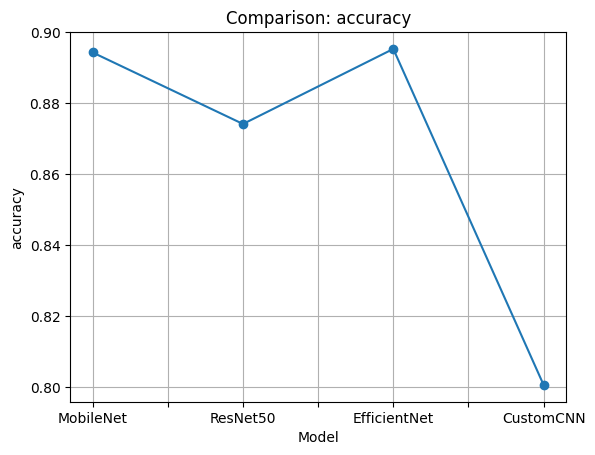

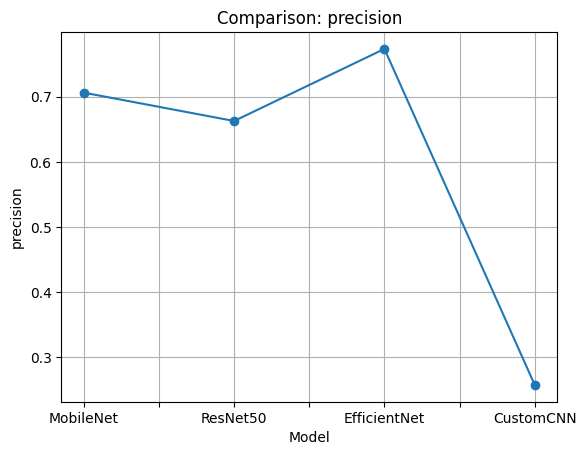

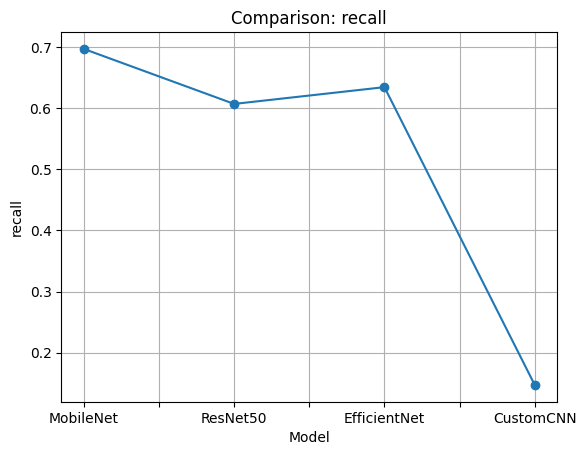

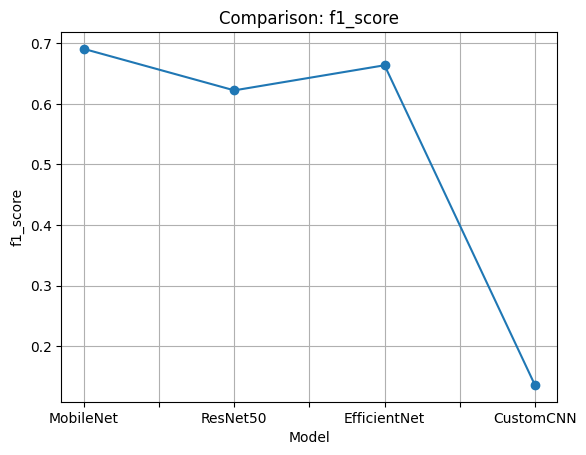

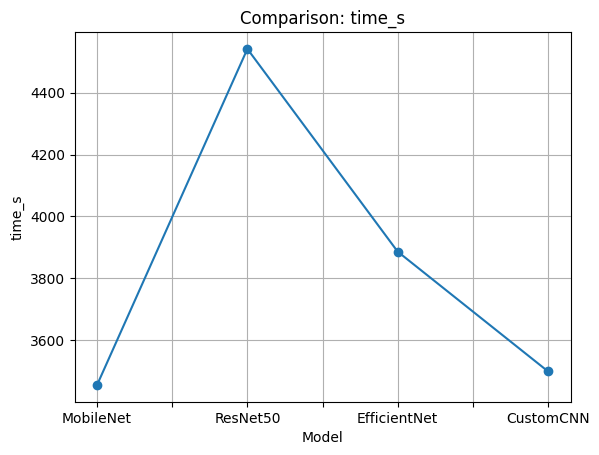

In [ ]:
print(df)

for metric in ['accuracy','precision','recall','f1_score','time_s']:
    plt.figure()
    df[metric].plot(marker='o')
    plt.title(f'Comparison: {metric}')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.grid(True)
plt.show()
